In [0]:
import keras
import cv2
import numpy as np
import pandas as pd
import tensorflow as tf
from itertools import count
from sklearn.metrics import accuracy_score
from keras.datasets import mnist
from keras.applications.vgg16 import VGG16
from keras.layers import Dense, Dropout, Flatten, Activation, Input, Conv2D, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D
from sklearn.model_selection import train_test_split
from keras.models import Model
from keras.callbacks import EarlyStopping
from scipy.stats import pearsonr
from tqdm import tqdm

In [0]:
BATCH_SIZE = 128
EPOCHS = 9999
IMAGE_SIZE = 28
NUM_CLASSES = 10
MODEL_ADDITION_DELTA = 0.01
MODEL_ADDITION_PATIENCE = 3
MODEL_NAME = "MNIST_bagging"
PATH = ""

# Set seeds

In [0]:
np.random.seed(3)
tf.random.set_seed(3)

# Preprocess

In [0]:
def preprocess(imgs):
    
    return imgs.reshape(imgs.shape[0], IMAGE_SIZE, IMAGE_SIZE, 1)

In [39]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = preprocess(x_train)
x_test = preprocess(x_test)

print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples


In [0]:
# Convert class vectors to binary class matrices.
y_train = keras.utils.to_categorical(y_train, NUM_CLASSES)
y_testc = keras.utils.to_categorical(y_test, NUM_CLASSES)

In [0]:
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

In [0]:
# Split the data
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.20, shuffle= True)

# Model

In [0]:
def MNISTmodel(imsize, num_classes, num_channels):
    inputs = Input((imsize,imsize,num_channels))
    x = Conv2D(filters=16, kernel_size=(3,3), activation='relu',strides = 2)(inputs)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='same')(x)
    x = Conv2D(filters=16, kernel_size=(1,1), activation='relu', padding='valid')(x)
    x = Conv2D(filters=10, kernel_size=(1,1),strides=(1,1), padding='valid')(x)
    x = GlobalAveragePooling2D()(x)
    outputs = Activation('softmax')(x)
    
    model = Model(inputs=inputs, outputs=outputs)

    optimizer = keras.optimizers.Adam(learning_rate = 1e-04)

    model.compile(loss='categorical_crossentropy',
                      optimizer=optimizer,
                      metrics=['accuracy'])
    return model

# Predict

In [0]:
def predict(models, X, Y):
    predictions = []

    for m in tqdm(models):
        predictions.append(np.argmax(m.predict(X), axis=1))

    prediction = np.transpose(predictions)
    prediction = np.apply_along_axis(lambda x: np.bincount(x).argmax(), axis=1, arr=prediction)

    return accuracy_score(prediction, np.argmax(Y, axis=1))

# Train

In [45]:
models = []
accuracies = [0]
patience = 0

for i in count(1):

    print(f"Train model {i}")
    idx = np.random.choice(len(x_train), size=len(x_train), replace=True)

    x_train_model = x_train[idx]
    y_train_model = y_train[idx]

    model = MNISTmodel(IMAGE_SIZE, NUM_CLASSES, 1)
    
    es = EarlyStopping(min_delta=0.01, patience=3)
    model.fit(x_train_model,y_train_model,
              batch_size = BATCH_SIZE,
              epochs = EPOCHS,
              validation_data = (x_val, y_val),
              shuffle = True,
              callbacks=[es])
    
    model.save_weights(PATH + MODEL_NAME + f"_weights-{i}.h5" )
    models.append(model)

    acc = predict(models, x_val, y_val)
    delta = acc - accuracies[-1]

    accuracies.append(acc)

    if delta >= MODEL_ADDITION_DELTA:
      patience = 0
    else:
      patience += 1

    print(f"Model: {i} added. Resulting score: {acc}, Delta: {delta}, Patience: {patience}")

    if patience >= MODEL_ADDITION_PATIENCE:
      break

Train model 1
Train on 48000 samples, validate on 12000 samples
Epoch 1/9999
48000/48000 [==============================] - 4s 80us/step - loss: 2.3171 - accuracy: 0.1270 - val_loss: 2.2916 - val_accuracy: 0.1238
Epoch 2/9999
48000/48000 [==============================] - 3s 71us/step - loss: 2.2695 - accuracy: 0.1580 - val_loss: 2.2604 - val_accuracy: 0.1623
Epoch 3/9999
48000/48000 [==============================] - 3s 71us/step - loss: 2.2369 - accuracy: 0.2033 - val_loss: 2.2191 - val_accuracy: 0.2243
Epoch 4/9999
48000/48000 [==============================] - 4s 74us/step - loss: 2.1909 - accuracy: 0.2580 - val_loss: 2.1653 - val_accuracy: 0.2654
Epoch 5/9999
48000/48000 [==============================] - 3s 72us/step - loss: 2.1328 - accuracy: 0.2848 - val_loss: 2.1007 - val_accuracy: 0.2910
Epoch 6/9999
48000/48000 [==============================] - 3s 72us/step - loss: 2.0648 - accuracy: 0.3070 - val_loss: 2.0273 - val_accuracy: 0.3147
Epoch 7/9999
48000/48000 [================

100%|██████████| 1/1 [00:00<00:00,  1.56it/s]


Model: 1 added. Resulting score: 0.5749166666666666, Delta: 0.5749166666666666, Patience: 0
Train model 2
Train on 48000 samples, validate on 12000 samples
Epoch 1/9999
48000/48000 [==============================] - 4s 75us/step - loss: 2.2947 - accuracy: 0.1666 - val_loss: 2.2857 - val_accuracy: 0.1848
Epoch 2/9999
48000/48000 [==============================] - 3s 69us/step - loss: 2.2513 - accuracy: 0.2163 - val_loss: 2.2364 - val_accuracy: 0.2147
Epoch 3/9999
48000/48000 [==============================] - 3s 68us/step - loss: 2.2092 - accuracy: 0.2310 - val_loss: 2.1819 - val_accuracy: 0.2403
Epoch 4/9999
48000/48000 [==============================] - 3s 68us/step - loss: 2.1507 - accuracy: 0.2480 - val_loss: 2.1162 - val_accuracy: 0.2799
Epoch 5/9999
48000/48000 [==============================] - 3s 67us/step - loss: 2.0792 - accuracy: 0.2747 - val_loss: 2.0407 - val_accuracy: 0.2911
Epoch 6/9999
48000/48000 [==============================] - 3s 67us/step - loss: 2.0068 - accuracy:

100%|██████████| 2/2 [00:01<00:00,  1.63it/s]


Model: 2 added. Resulting score: 0.61025, Delta: 0.03533333333333333, Patience: 0
Train model 3
Train on 48000 samples, validate on 12000 samples
Epoch 1/9999
48000/48000 [==============================] - 4s 74us/step - loss: 2.3116 - accuracy: 0.0985 - val_loss: 2.2895 - val_accuracy: 0.1418
Epoch 2/9999
48000/48000 [==============================] - 3s 67us/step - loss: 2.2422 - accuracy: 0.1374 - val_loss: 2.2245 - val_accuracy: 0.1589
Epoch 3/9999
48000/48000 [==============================] - 3s 69us/step - loss: 2.1898 - accuracy: 0.1722 - val_loss: 2.1631 - val_accuracy: 0.1823
Epoch 4/9999
48000/48000 [==============================] - 3s 72us/step - loss: 2.1288 - accuracy: 0.2072 - val_loss: 2.0968 - val_accuracy: 0.2240
Epoch 5/9999
48000/48000 [==============================] - 4s 74us/step - loss: 2.0595 - accuracy: 0.2916 - val_loss: 2.0236 - val_accuracy: 0.3175
Epoch 6/9999
48000/48000 [==============================] - 3s 72us/step - loss: 1.9878 - accuracy: 0.3429 - 

100%|██████████| 3/3 [00:01<00:00,  1.69it/s]


Model: 3 added. Resulting score: 0.6526666666666666, Delta: 0.04241666666666666, Patience: 0
Train model 4
Train on 48000 samples, validate on 12000 samples
Epoch 1/9999
48000/48000 [==============================] - 4s 74us/step - loss: 2.3438 - accuracy: 0.1056 - val_loss: 2.2968 - val_accuracy: 0.1248
Epoch 2/9999
48000/48000 [==============================] - 3s 67us/step - loss: 2.2745 - accuracy: 0.1284 - val_loss: 2.2609 - val_accuracy: 0.1732
Epoch 3/9999
48000/48000 [==============================] - 3s 67us/step - loss: 2.2398 - accuracy: 0.1891 - val_loss: 2.2216 - val_accuracy: 0.2065
Epoch 4/9999
48000/48000 [==============================] - 3s 67us/step - loss: 2.1967 - accuracy: 0.2377 - val_loss: 2.1702 - val_accuracy: 0.2542
Epoch 5/9999
48000/48000 [==============================] - 3s 67us/step - loss: 2.1376 - accuracy: 0.2985 - val_loss: 2.1005 - val_accuracy: 0.3344
Epoch 6/9999
48000/48000 [==============================] - 3s 66us/step - loss: 2.0586 - accuracy

100%|██████████| 4/4 [00:02<00:00,  1.71it/s]


Model: 4 added. Resulting score: 0.64725, Delta: -0.005416666666666625, Patience: 1
Train model 5
Train on 48000 samples, validate on 12000 samples
Epoch 1/9999
48000/48000 [==============================] - 4s 80us/step - loss: 2.3468 - accuracy: 0.1033 - val_loss: 2.2982 - val_accuracy: 0.1212
Epoch 2/9999
48000/48000 [==============================] - 3s 72us/step - loss: 2.2715 - accuracy: 0.1488 - val_loss: 2.2540 - val_accuracy: 0.1506
Epoch 3/9999
48000/48000 [==============================] - 3s 73us/step - loss: 2.2301 - accuracy: 0.1792 - val_loss: 2.2086 - val_accuracy: 0.1857
Epoch 4/9999
48000/48000 [==============================] - 4s 74us/step - loss: 2.1842 - accuracy: 0.2164 - val_loss: 2.1577 - val_accuracy: 0.2247
Epoch 5/9999
48000/48000 [==============================] - 4s 76us/step - loss: 2.1286 - accuracy: 0.2859 - val_loss: 2.0958 - val_accuracy: 0.3212
Epoch 6/9999
48000/48000 [==============================] - 4s 75us/step - loss: 2.0588 - accuracy: 0.3518 

100%|██████████| 5/5 [00:02<00:00,  1.70it/s]


Model: 5 added. Resulting score: 0.6608333333333334, Delta: 0.013583333333333392, Patience: 0
Train model 6
Train on 48000 samples, validate on 12000 samples
Epoch 1/9999
48000/48000 [==============================] - 4s 81us/step - loss: 2.2853 - accuracy: 0.1164 - val_loss: 2.2851 - val_accuracy: 0.1080
Epoch 2/9999
48000/48000 [==============================] - 3s 73us/step - loss: 2.2421 - accuracy: 0.1341 - val_loss: 2.2294 - val_accuracy: 0.1454
Epoch 3/9999
48000/48000 [==============================] - 4s 75us/step - loss: 2.2018 - accuracy: 0.1935 - val_loss: 2.1752 - val_accuracy: 0.2620
Epoch 4/9999
48000/48000 [==============================] - 4s 73us/step - loss: 2.1352 - accuracy: 0.2867 - val_loss: 2.0945 - val_accuracy: 0.3101
Epoch 5/9999
48000/48000 [==============================] - 3s 72us/step - loss: 2.0553 - accuracy: 0.3168 - val_loss: 2.0095 - val_accuracy: 0.3210
Epoch 6/9999
48000/48000 [==============================] - 3s 70us/step - loss: 1.9749 - accurac

100%|██████████| 6/6 [00:03<00:00,  1.72it/s]


Model: 6 added. Resulting score: 0.664, Delta: 0.003166666666666651, Patience: 1
Train model 7
Train on 48000 samples, validate on 12000 samples
Epoch 1/9999
48000/48000 [==============================] - 4s 86us/step - loss: 2.3296 - accuracy: 0.1132 - val_loss: 2.2944 - val_accuracy: 0.1072
Epoch 2/9999
48000/48000 [==============================] - 4s 76us/step - loss: 2.2648 - accuracy: 0.1701 - val_loss: 2.2495 - val_accuracy: 0.2148
Epoch 3/9999
48000/48000 [==============================] - 4s 76us/step - loss: 2.2210 - accuracy: 0.2564 - val_loss: 2.1984 - val_accuracy: 0.2706
Epoch 4/9999
48000/48000 [==============================] - 4s 75us/step - loss: 2.1683 - accuracy: 0.2742 - val_loss: 2.1385 - val_accuracy: 0.2702
Epoch 5/9999
48000/48000 [==============================] - 4s 76us/step - loss: 2.1046 - accuracy: 0.2778 - val_loss: 2.0695 - val_accuracy: 0.2774
Epoch 6/9999
48000/48000 [==============================] - 4s 76us/step - loss: 2.0344 - accuracy: 0.2893 - v

100%|██████████| 7/7 [00:03<00:00,  1.78it/s]


Model: 7 added. Resulting score: 0.6586666666666666, Delta: -0.005333333333333412, Patience: 2
Train model 8
Train on 48000 samples, validate on 12000 samples
Epoch 1/9999
48000/48000 [==============================] - 4s 76us/step - loss: 2.2743 - accuracy: 0.1624 - val_loss: 2.2704 - val_accuracy: 0.1743
Epoch 2/9999
48000/48000 [==============================] - 3s 68us/step - loss: 2.2043 - accuracy: 0.2536 - val_loss: 2.1775 - val_accuracy: 0.2790
Epoch 3/9999
48000/48000 [==============================] - 3s 69us/step - loss: 2.1352 - accuracy: 0.2853 - val_loss: 2.0953 - val_accuracy: 0.2962
Epoch 4/9999
48000/48000 [==============================] - 3s 69us/step - loss: 2.0587 - accuracy: 0.2999 - val_loss: 2.0152 - val_accuracy: 0.2947
Epoch 5/9999
48000/48000 [==============================] - 3s 70us/step - loss: 1.9753 - accuracy: 0.3125 - val_loss: 1.9259 - val_accuracy: 0.3173
Epoch 6/9999
48000/48000 [==============================] - 3s 69us/step - loss: 1.8904 - accura

100%|██████████| 8/8 [00:04<00:00,  1.77it/s]

Model: 8 added. Resulting score: 0.6653333333333333, Delta: 0.00666666666666671, Patience: 3


# Results

# Accuracy vs nr of models
Visualizing the accuracy vs the number of models in the ensamble

In [46]:
accuracy_df = pd.DataFrame(accuracies, columns=["Accuracy"])
accuracy_df.insert(1, "Nr of models", accuracy_df.index)

display(accuracy_df)

accuracy_df.to_csv(PATH + MODEL_NAME + "_accuracy.csv")

,Accuracy,Nr of models
0,0.000000,0
1,0.574917,1
2,0.610250,2
3,0.652667,3
4,0.647250,4
5,0.660833,5
6,0.664000,6
7,0.658667,7
8,0.665333,8


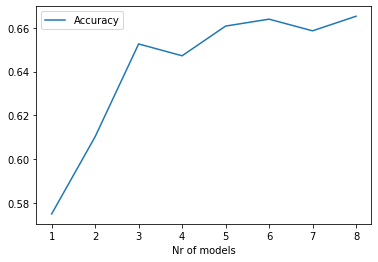

In [47]:
import matplotlib.pyplot as plt

# remove first row
accuracy_df = accuracy_df.iloc[1:]

accuracy_df.plot(x="Nr of models", y="Accuracy", xticks=accuracy_df["Nr of models"])
plt.show()

## Accuracy
The final accuracy of the ensamble on the test set

In [48]:
print("Accuracy: " + str(predict(models, x_test, y_testc)))

100%|██████████| 8/8 [00:03<00:00,  2.15it/s]

Accuracy: 0.6738


## Correlation between models

In [49]:
predictions = []

for m in tqdm(models):
    predictions.append(np.argmax(m.predict(x_test), axis=1))

100%|██████████| 8/8 [00:03<00:00,  2.13it/s]


In [50]:
classified = []

for prediction in tqdm(predictions):
    classified.append([1 if i==j else 0 for i,j in zip(prediction,y_test)])

100%|██████████| 8/8 [00:00<00:00, 220.25it/s]


In [51]:
correlation_matrix = []

for ix, x in enumerate(classified):
  row = []
  
  for iy, y in enumerate(classified):
    if (ix == iy):
      row.append(np.nan)
    else:
      row.append(pearsonr(x,y)[0])

  correlation_matrix.append(row)

correlation_matrix = np.array(correlation_matrix)
correlation_matrix_df = pd.DataFrame(correlation_matrix)
correlation_matrix_df.to_csv(PATH + MODEL_NAME + "_correlation_matrix.csv")
display(correlation_matrix_df)
print("Average correlation: " + str(np.nanmean(correlation_matrix.flatten())))

,0,1,2,3,4,5,6,7
0,NaN,0.512169,0.540650,0.605160,0.564238,0.570062,0.589366,0.569460
1,0.512169,NaN,0.552157,0.556182,0.606458,0.596311,0.565229,0.525176
2,0.540650,0.552157,NaN,0.579858,0.602908,0.583544,0.534917,0.562541
3,0.605160,0.556182,0.579858,NaN,0.590426,0.580155,0.582139,0.545352
4,0.564238,0.606458,0.602908,0.590426,NaN,0.645982,0.591389,0.605792
5,0.570062,0.596311,0.583544,0.580155,0.645982,NaN,0.589333,0.577090
6,0.589366,0.565229,0.534917,0.582139,0.591389,0.589333,NaN,0.546601
7,0.569460,0.525176,0.562541,0.545352,0.605792,0.577090,0.546601,NaN


Average correlation: 0.5739516301306774
